In [1]:
%load_ext pretty_jupyter

In [2]:
import os,re
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from itertools import product
from datetime import datetime

import matplotlib.pyplot as plt
from pretty_jupyter.helpers import matplotlib_fig_to_html, matplotlib_fig_to_markdown
from IPython.display import display, Markdown

import seaborn as sns
from sklearn.linear_model import LinearRegression

import geopandas
import plotly.express as px

import plot_crime as pc


%load_ext autoreload
%autoreload 2
# %matplotlib inline
# %load_ext genai

In [3]:
base_dir = 'C:\\Users\\BatLab\\Documents\\chicago_crime'
crime_by_year_fname = os.path.join(base_dir,'crime_by_year_dfs.pkl')
crime_by_year_dfs = pd.read_pickle(crime_by_year_fname)

In [4]:
return_raw = False
community_areas, demographics, nibrs_codes, iucr_codes, population, _ = pc.init_crime_data(return_raw)

In [5]:
cca_regions = community_areas.Region.unique()

# Crime Plots

In [6]:
crime_type = 'FBI_type'
place_type = 'region'
select_places = None
select_crimes = None

In [ ]:
%%jmd
## Plotting {{ crime_type.replace('_',' ') }} by {{ place_type.title() }}

In [ ]:
_=pc.plot_crime_by_type_and_place(
    crime_by_year_dfs,
    population,
    crime_type,
    place_type,
    community_areas=community_areas,
    cca_regions=cca_regions,
    select_places=select_places,
    select_crimes=select_crimes
)

In [ ]:
crime_type = 'FBI_type'
place_type = 'Community Area'

In [ ]:
%%jmd
## Plotting {{ crime_type.replace('_',' ') }} by {{ place_type.title() }}
[//]: # (-.- .tabset .tabset-pills .tabset-fade)

In [ ]:
for region in cca_regions:
    select_places = community_areas.query('Region == @region').index
    display(Markdown(f"### {region.title()}"))
    fig=pc.plot_crime_by_type_and_place(
        crime_by_year_dfs,
        population,
        crime_type,
        place_type,
        community_areas=community_areas,
        cca_regions=cca_regions,
        select_places=select_places,
        select_crimes=select_crimes
    )
    display(Markdown(matplotlib_fig_to_markdown(fig)))

In [ ]:
%%jmd
## Plotting Select Crimes by Region
[//]: # (-.- .tabset .tabset-pills .tabset-fade)

In [8]:
select_crime_lists = {
    'weapons_and_homocide':['homicide','weapons'],
    'stealing':['larceny', 'burglary', 'robbery','vehicle_theft'],
    'assault_and_battery':['simple_battery','simple_assault','aggravated_battery', 'aggravated_assault','sexual_assault'],
    'society':['vandalism', 'misc', 'drug_abuse', 'fraud','sexual_abuse', 'disorderly_conduct']
}

### Weapons And Homocide

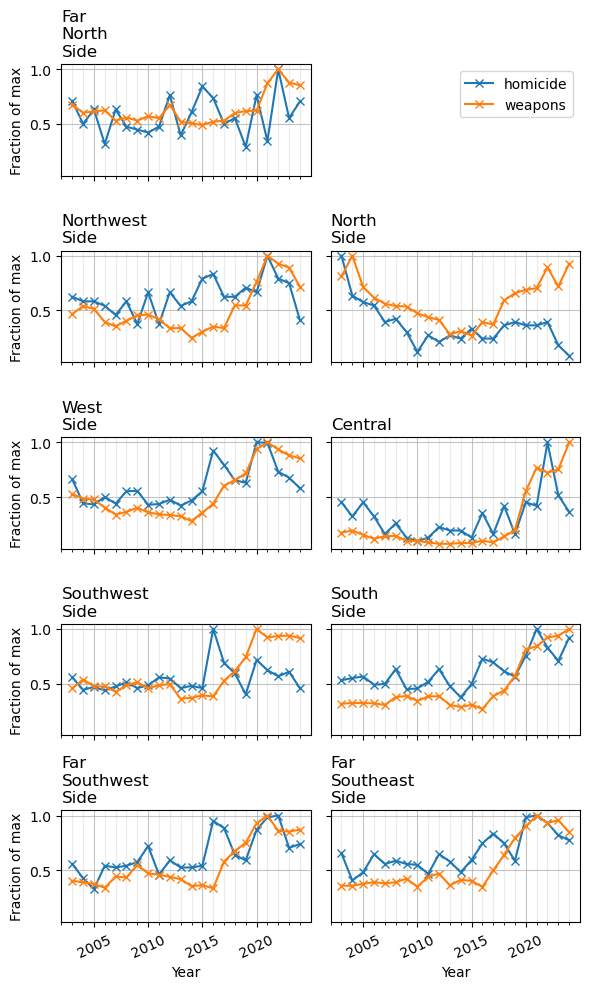

### Stealing

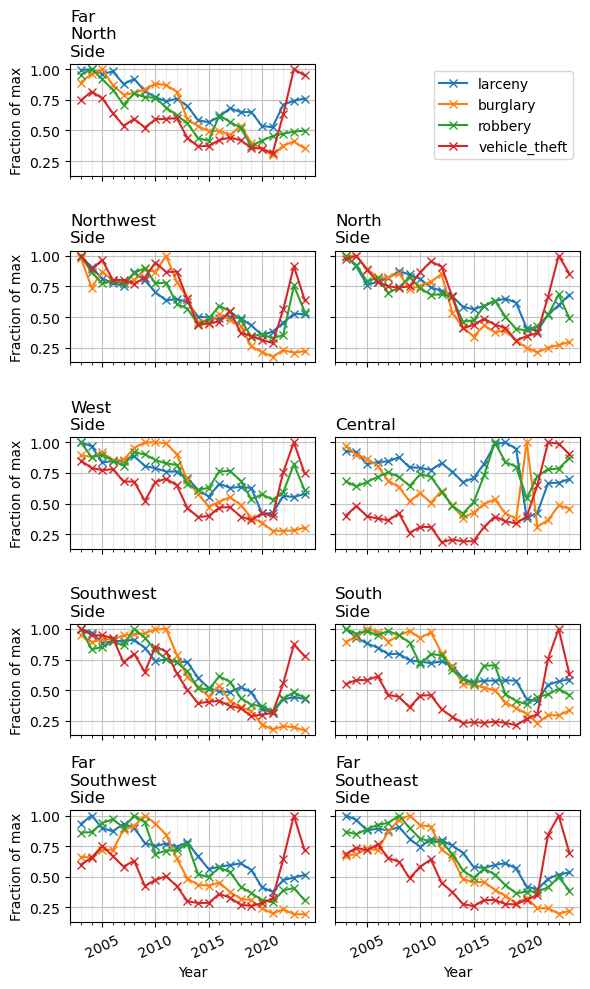

### Assault And Battery

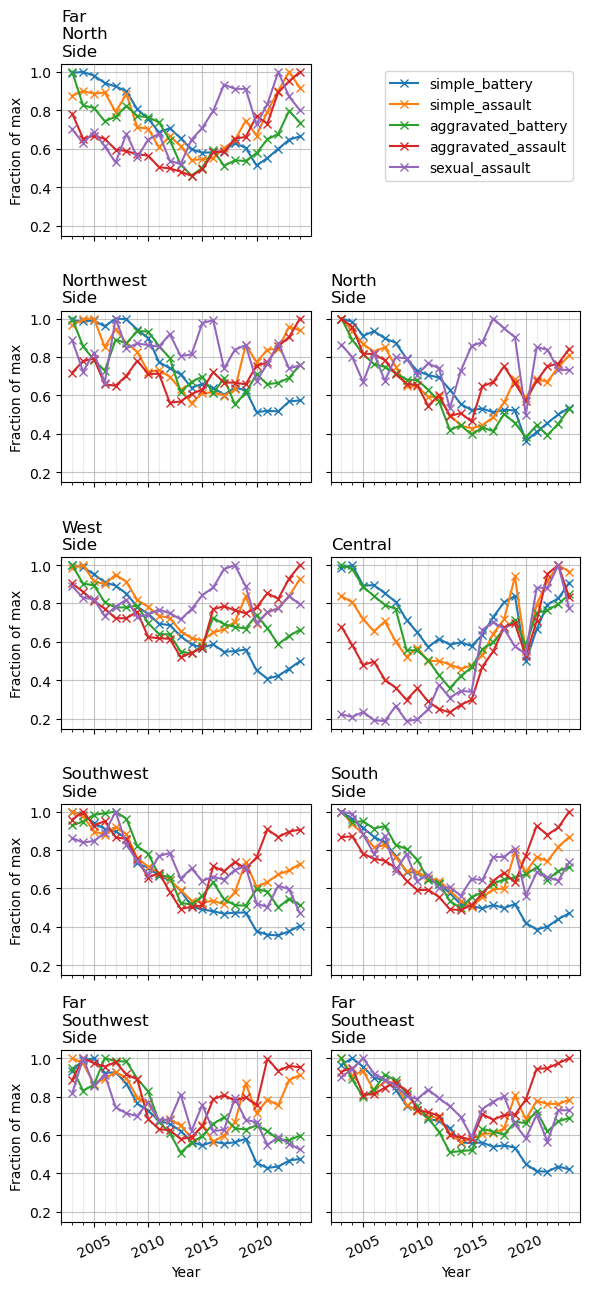

### Society

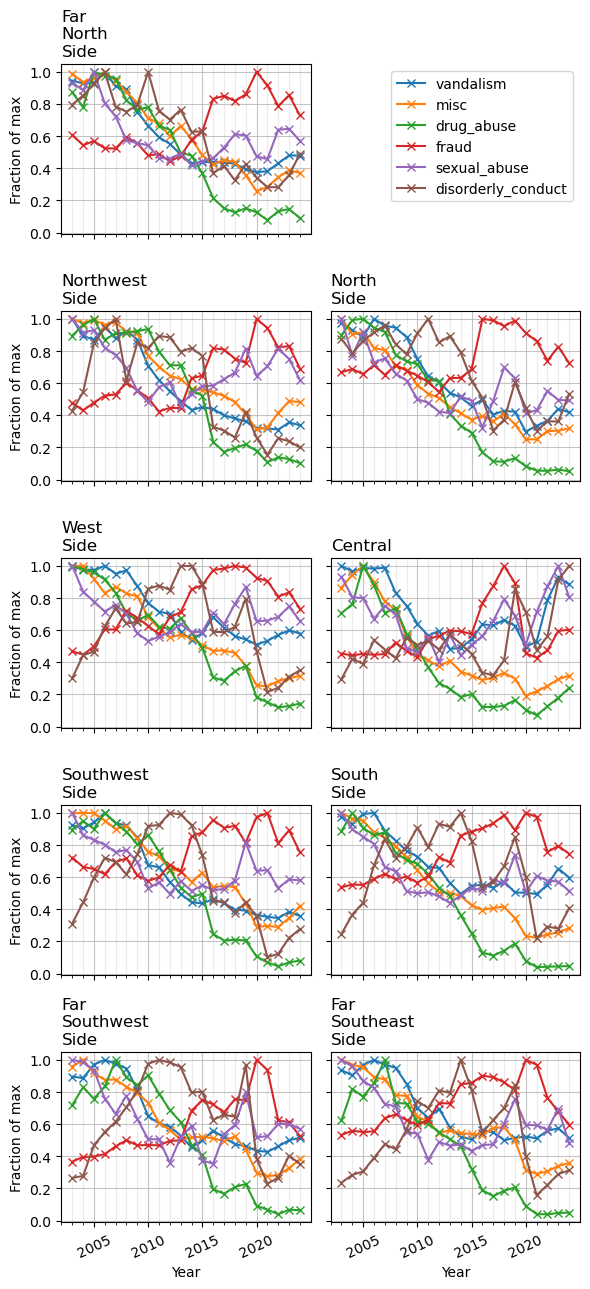

In [20]:
for select_crime_type in select_crime_lists:
    display(Markdown(f"### {select_crime_type.replace('_',' ').title()}"))
    fig = pc.plot_regional_crime(
        crime_by_year_dfs,
        population,
        crime_type,
        select_crimes=select_crime_lists[select_crime_type],
        plot_pop=False,
        show_max_text_box=False
    )
    display(Markdown(matplotlib_fig_to_markdown(fig)))

In [34]:
select_crime_type = 'stealing'
region = 'South Side'
select_crimes=select_crime_lists[select_crime_type]
data_df = crime_by_year_dfs[(crime_type,'region')].copy()
d = (
    data_df[select_crimes]
    .xs(region,level='region',axis=1)
    .drop(pc.drop_years,errors='ignore')
)

In [115]:
df = data_df[select_crimes].drop(pc.drop_years).reset_index()

In [116]:
df = df.melt(id_vars='Year',value_name='Crime Total')


In [109]:
(
    df
    .groupby(['FBI_type','region'],sort=False)
    .apply(lambda x: x['Crime Total']/x['Crime Total'].max())
    .melt(value_name='Crime Total',ignore_index=False)
    # .rename('Crime Rate (% Max)')
)

Year  Crime Total
FBI_type      region                               
larceny       Central             2003     0.926396
              Far North Side      2003     0.993050
              Far Southeast Side  2003     1.000000
              Far Southwest Side  2003     0.930983
              North Side          2003     1.000000
...                                ...          ...
vehicle_theft North Side          2024     0.853457
              Northwest Side      2024     0.641312
              South Side          2024     0.630764
              Southwest Side      2024     0.776967
              West Side           2024     0.746624

[792 rows x 2 columns]

In [92]:
df

,Year,FBI_type,region,Crime Total
0,2003,larceny,Central,11617.000000
1,2004,larceny,Central,11562.000000
2,2005,larceny,Central,10300.000000
3,2006,larceny,Central,10537.000000
4,2007,larceny,Central,10590.000000
...,...,...,...,...
787,2020,vehicle_theft,West Side,2767.000000
788,2021,vehicle_theft,West Side,2622.000000
789,2022,vehicle_theft,West Side,4983.000000
790,2023,vehicle_theft,West Side,6578.000000


In [60]:
plot_data = (d/d.max()).reset_index()
plot_data = plot_data.melt(id_vars=['Year'],value_name='Crime Rate')

plot_data= plot_data.merge(
    d.reset_index().melt(id_vars=['Year'],value_name='Crime Total'),
    on=['Year','FBI_type']
)

In [61]:
plot_data.head()

,Year,FBI_type,Crime Rate,Crime Total
0,2003,larceny,1.000000,11623.0
1,2004,larceny,0.928762,10795.0
2,2005,larceny,0.881184,10242.0
3,2006,larceny,0.847200,9847.0
4,2007,larceny,0.794975,9240.0


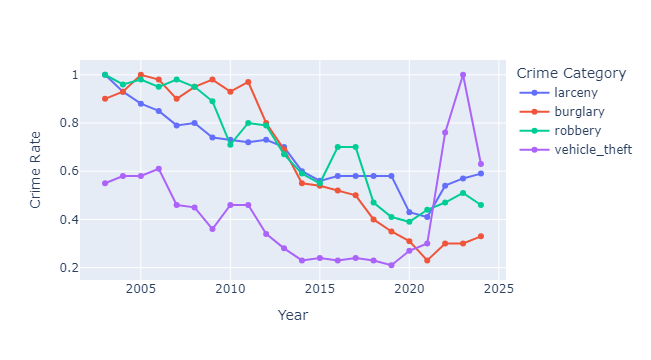

In [71]:
fig = px.line(
    plot_data.round(decimals=2),
    x = 'Year',
    y = 'Crime Rate',
    color = 'FBI_type',
    hover_data = {'Year':False,'FBI_type':False,'Crime Total':True},
    labels={'FBI_type': 'Crime Category'}
)
fig.update_traces(mode="markers+lines")
fig.update_layout(hovermode="x unified")
# fig.update_xaxes(range=[2002, 2025])
# fig.update_yaxes(range=[0, 1])

fig.show()

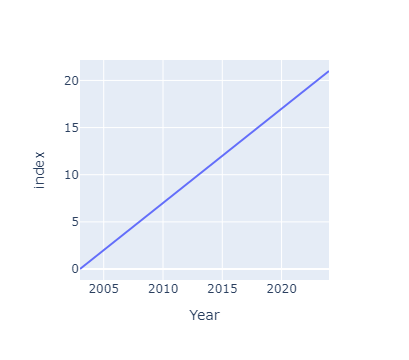

In [57]:
fig = px.line(
    d.reset_index(),
    x = 'Year',
    # y = [col+'-scaled' for col in plot_data_scaled.columns]
)
fig.show()